# Imports
note book for random doodles

In [72]:
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f


from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
# from sklearn.linear_model import Lasso, Ridge  # For regularized regression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier

# #metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, roc_curve, auc
# from sklearn.datasets import make_classification


# EDA

In [73]:
X,y  = load_wine(return_X_y=True, as_frame=True)
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

<Axes: >

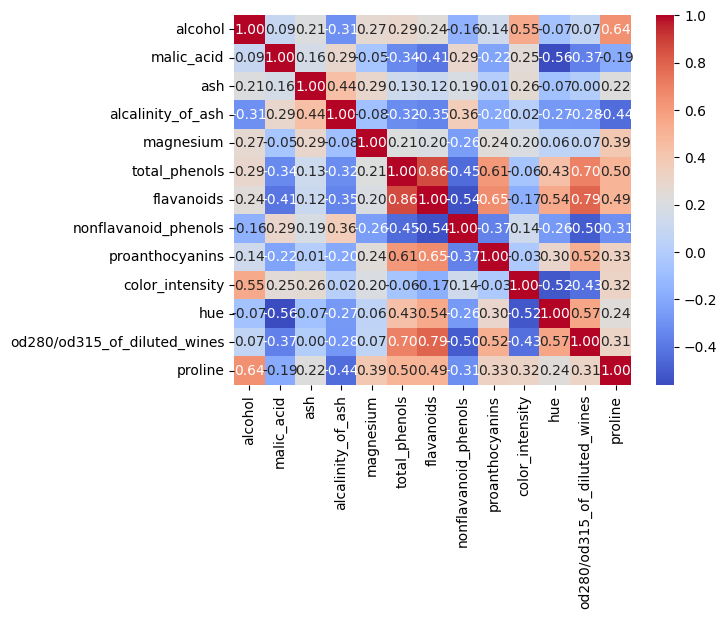

In [83]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("Feature Correlation Heatmap")
# plt.show()
corr_matrix, p_value_matrix = f.corr_with_pvalues(X)
corr_matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

<Axes: >

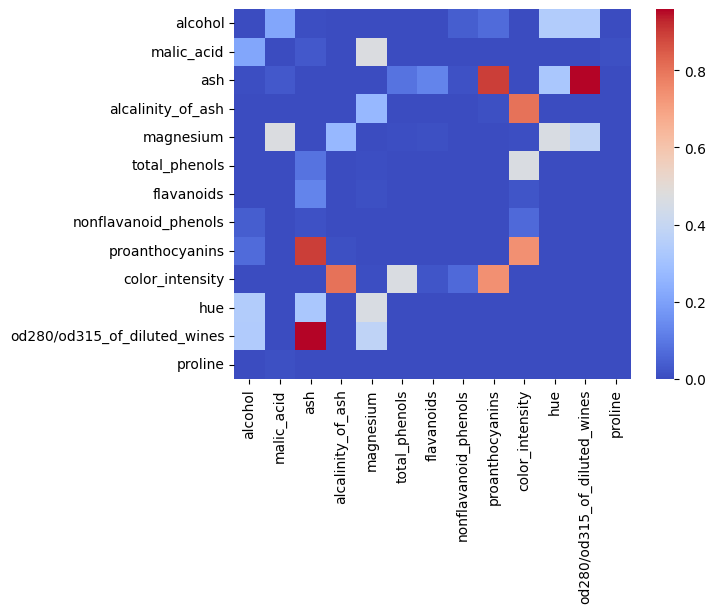

In [81]:
pval_corr_matrix = sns.heatmap(p_value_matrix, annot=False, cmap='coolwarm', fmt=".2f")
pval_corr_matrix

In [76]:
X,y  = load_wine(return_X_y=True, as_frame=True)
rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=rng)

pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier(random_state=rng))
        
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred
class_report = classification_report(y_test, y_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.88      0.93        16
           2       0.86      1.00      0.92         6

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.95      0.94      0.94        36



In [77]:
param_grid = {
    'model__n_estimators':[125,150,175],
    'model__learning_rate': [0.1, 0.3, 0.5, 0.7]
}
grid = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
class_report = classification_report(y_test, y_pred)

In [78]:
print(class_report)
print(grid.best_estimator_)
print(grid.best_params_)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.88      0.93        16
           2       0.86      1.00      0.92         6

    accuracy                           0.94        36
   macro avg       0.93      0.96      0.94        36
weighted avg       0.95      0.94      0.94        36

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(n_estimators=150,
                                            random_state=RandomState(MT19937) at 0x1127A4E40))])
{'model__learning_rate': 0.1, 'model__n_estimators': 150}


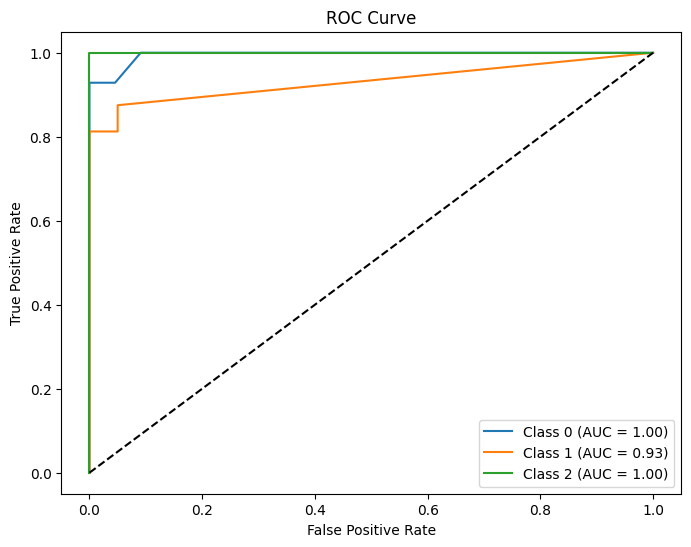

In [79]:
# Binarize y_test for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], pipeline.decision_function(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# End